# 中文评论情感分析(keras+rnn）

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
#KeyedVectors实现实体（单词、文档、图片都可以）和向量之间的映射，实体都用string id表示
#有时候运行代码时会有很多warning输出，如提醒新版本之类的，如果不想乱糟糟的输出可以这样

In [4]:
# 预训练词向量
# 使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('data/sgns.zhihu.bigram',
                                          binary=False)
# 词向量模型
# 在这个词向量模型里，每一个词是一个索引，对应的是一个长度为300的向量，我们今天需要构建的LSTM神经网络模型并不能直接处理汉字文本，
# 需要先进行分次并把词汇转换为词向量，步骤请参考：
# 0.原始文本：我喜欢文学
# 1.分词：我，喜欢，文学
# 2.Tokenize(索引化)：[2,345，4564]
# 3.Embedding(词向量化)：用一个300维的词向量，上面的tokens成为一个[3，300]的矩阵
# 4.RNN:1DCONV,GRU,LSTM等
# 5.经过激活函数输出分类：如sigmoid输出在0到1间
# 由此可见每一个词都对应一个长度为300的向量

In [5]:
embedding_dim = cn_model['山东大学'].shape[0]  #一词山东大学，shape[0]返回行数
print('词向量的长度为{}'.format(embedding_dim))
print(cn_model['山东大学'])

# 计算相似度
print(cn_model.similarity('橘子', '橙子'))

# dot（'橘子'/|'橘子'|， '橙子'/|'橙子'| ），余弦相似度
sim = np.dot(cn_model['橘子']/np.linalg.norm(cn_model['橘子']),
        cn_model['橙子']/np.linalg.norm(cn_model['橙子']))
print("sim: ", sim)

词向量的长度为300
[-2.603470e-01  3.677500e-01 -2.379650e-01  5.301700e-02 -3.628220e-01
 -3.212010e-01 -1.903330e-01  1.587220e-01 -7.156200e-02 -4.625400e-02
 -1.137860e-01  3.515600e-01 -6.408200e-02 -2.184840e-01  3.286950e-01
 -7.110330e-01  1.620320e-01  1.627490e-01  5.528180e-01  1.016860e-01
  1.060080e-01  7.820700e-01 -7.537310e-01 -2.108400e-02 -4.758250e-01
 -1.130420e-01 -2.053000e-01  6.624390e-01  2.435850e-01  9.171890e-01
 -2.090610e-01 -5.290000e-02 -7.969340e-01  2.394940e-01 -9.028100e-02
  1.537360e-01 -4.003980e-01 -2.456100e-02 -1.717860e-01  2.037790e-01
 -4.344710e-01 -3.850430e-01 -9.366000e-02  3.775310e-01  2.659690e-01
  8.879800e-02  2.493440e-01  4.914900e-02  5.996000e-03  3.586430e-01
 -1.044960e-01 -5.838460e-01  3.093280e-01 -2.828090e-01 -8.563400e-02
 -5.745400e-02 -2.075230e-01  2.845980e-01  1.414760e-01  1.678570e-01
  1.957560e-01  7.782140e-01 -2.359000e-01 -6.833100e-02  2.560170e-01
 -6.906900e-02 -1.219620e-01  2.683020e-01  1.678810e-01  2.068910

In [6]:
# 找出最相近的词，余弦相似度
print(cn_model.most_similar(positive=['大学'], topn=10))

[('高中', 0.7247823476791382), ('本科', 0.6768535375595093), ('研究生', 0.6244412660598755), ('中学', 0.6088204979896545), ('大学本科', 0.595908522605896), ('初中', 0.5883588790893555), ('读研', 0.5778335332870483), ('职高', 0.5767995119094849), ('大学毕业', 0.5767451524734497), ('师范大学', 0.5708829760551453)]


In [7]:
# 找出不同的词
test_words = '老师 会计师 程序员 律师 医生 老人'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

在 老师 会计师 程序员 律师 医生 老人 中:
不是同一类别的词为: 老人


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [8]:
cn_model.most_similar(positive=['女人','出轨'], negative=['男人'], topn=1)

[('劈腿', 0.5849199295043945)]

In [9]:
# 训练语料 （数据集）
# 本教程使用了酒店评论语料，训练样本分别被放置在两个文件夹里： 分别的pos和neg，
# 每个文件夹里有2000个txt文件，每个文件内有一段评语，共有4000个训练样本，这样大小的样本数据在NLP中属于非常迷你的

# 获得样本的索引，样本存放于两个文件夹中，
# 分别为 正面评价'pos'文件夹 和 负面评价'neg'文件夹
# 每个文件夹中有2000个txt文件，每个文件中是一例评价，一个对一个
import os
pos_txts = os.listdir('data/pos')
neg_txts = os.listdir('data/neg')
print( '样本总共: '+ str(len(pos_txts) + len(neg_txts)) )


样本总共: 4000


In [10]:
# 现在我们将所有的评价内容放置到一个list里
train_texts_orig = [] # 存储所有评价，每例评价为一条string，原始评论
# 添加完所有样本之后，train_texts_orig为一个含有4000条文本的list
# 其中前2000条文本为正面评价，后2000条为负面评价
#以下为读入.txt文件过程
for i in range(len(pos_txts)):
    with open('data/pos/'+pos_txts[i], 'r', errors='ignore',encoding='gbk') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('data/neg/'+neg_txts[i], 'r', errors='ignore',encoding='gbk') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()

In [11]:
train_texts_orig[:5]

['非常好的服务，不愧是四星以及Marrito连锁酒店。服务很专业',
 '这次在51期间通过电话订的2间豪华单间，到了一看，豪华单间就象套房一样，还是一室一厅的，位于22楼，视野开阔，客厅还放了很多介绍洛阳的旅游书。\n\n酒店地理位置也可以，离龙门石窟只有12公里，离市中心1公里。不足就是酒店设施稍旧。',
 '我在该宾馆入住了大约有20几次了吧，主要是觉得位置不错，交通方便。觉得难以忍受的是床垫实在是太太太硬了。',
 '酒店地理位置在古城区最繁华的十全街上，环境非常好，很有园林特色，让人感到很舒服很惬意！前台入住和退房的速度也很快，服务人员很友善，有问必答！房间也很有特色，墙上刻有金色的诗词，听说每个房间的诗词都不同呢！下次还会选择这里！',
 '很喜欢，而且解放北路也很漂亮，住这里晚上出来散步很好']

In [12]:
# 进行分词和tokenize
# train_tokens是一个长长的list，其中含有4000个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.318 seconds.
Prefix dict has been built successfully.


In [13]:
train_tokens[:2]

[[175, 72, 1, 1191, 13497, 4, 0, 273, 0, 12778, 1845, 1191, 34, 413],
 [817,
  15,
  8305,
  975,
  259,
  927,
  6247,
  1,
  278,
  941,
  8707,
  25453,
  48,
  3,
  0,
  8707,
  25453,
  0,
  9050,
  134,
  57,
  0,
  0,
  1,
  3056,
  2734,
  1425,
  4416,
  10236,
  4265,
  0,
  3,
  87,
  1113,
  8693,
  1,
  1588,
  473,
  1845,
  11670,
  18,
  35,
  1027,
  171950,
  186,
  668,
  1149,
  1027,
  9724,
  280,
  1149,
  1803,
  25,
  0,
  0]]

In [14]:
# 索引长度标准化
# 因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，
# 这样十分浪费计算资源，所以我们取一个折衷的长度。

# 获得所有tokens的长度
num_tokens = [len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)
# 平均tokens的长度
np.mean(num_tokens)

71.42575

In [15]:
# 最长的评价tokens的长度
np.max(num_tokens)

1540

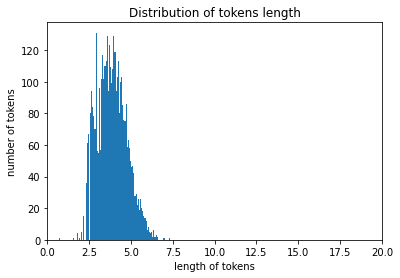

In [16]:
plt.hist(np.log(num_tokens), bins = 100)#有大有小取对数
plt.xlim((0,20))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [17]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
print(max_tokens)

236


In [18]:
# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
print(np.sum(num_tokens < max_tokens) / len(num_tokens))

0.9565


In [19]:
# 反向tokenize
# 为了之后来验证 我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [20]:
reverse = reverse_tokens(train_tokens[1])

In [21]:
# 经过tokenize再恢复成文本
# 可见标点符号都没有了
reverse

'这次在51期间通过电话订的2间豪华单间到了 豪华单间 套房一样还是  的位于22楼视野开阔客厅 了很多介绍洛阳的旅游书酒店地理位置也可以离龙门石窟只有12公里离市中心1公里不足就是  '

In [22]:
train_texts_orig[1]

'这次在51期间通过电话订的2间豪华单间，到了一看，豪华单间就象套房一样，还是一室一厅的，位于22楼，视野开阔，客厅还放了很多介绍洛阳的旅游书。\n\n酒店地理位置也可以，离龙门石窟只有12公里，离市中心1公里。不足就是酒店设施稍旧。'

In [23]:
cn_model.index2word[1]

'的'

In [24]:
# 构建embedding matrix
# 现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为(numwords, embeddingdim)的矩阵
# 【num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，
# 每一个词汇都用一个长度为300的向量表示】注意我们只选择使用前50k个使用频率最高的词，在这个预训练词向量模型中，
# 一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，
# 200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

# 只使用大库前50000个词
num_words = 50000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')


In [25]:
embedding_matrix

array([[-8.017840e-01, -1.653400e-01,  3.050800e-02, ...,  1.065250e-01,
         5.534360e-01,  4.366500e-01],
       [-6.517470e-01,  5.359700e-01,  3.402710e-01, ...,  8.053990e-01,
         1.045930e-01,  1.936940e-01],
       [-4.123210e-01,  2.282610e-01,  2.071140e-01, ...,  8.087770e-01,
         5.675100e-02,  4.523740e-01],
       ...,
       [ 5.849840e-01,  1.121180e-01, -6.938330e-01, ..., -3.760570e-01,
         1.203500e-01, -1.059511e+00],
       [ 1.511710e-01, -3.200000e-04, -3.885760e-01, ..., -5.988550e-01,
         4.273530e-01, -3.922630e-01],
       [-4.536090e-01, -1.813600e-02, -1.306600e-01, ..., -6.608000e-02,
         3.566680e-01,  3.898050e-01]], dtype=float32)

In [26]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

300

In [27]:
# padding(填充)和truncating(修剪)
# 我们把文本转换为tokens（索引）之后，每一串索引的长度并不相等，所以为了方便模型的训练我们需要把索引的长度标准化，
# 上面我们选择了236这个可以涵盖95%训练样本的长度，接下来我们进行padding和truncating，我们一般采用’pre’的方法，
# 这会在文本索引的前面填充0，因为根据一些研究资料中的实践，如果在文本索引后面填充0的话，会对模型造成一些不良影响。
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
from keras.preprocessing.sequence import pad_sequences

train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

# 超出五万个词向量的词用0代替
train_pad[ train_pad>=num_words ] = 0


# 可见padding之后前面的tokens全变成0，文本在最后面
print(train_pad[33])

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [28]:
# 准备target向量，前2000样本为1，后2000为0
train_target = np.concatenate( (np.ones(2000),np.zeros(2000)) )

In [29]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [30]:
train_target.shape

(4000,)

In [31]:
train_pad.shape

(4000, 236)

In [32]:
# 90%的样本用来训练，剩余10%用来测试
#因为前2000个文件夹都是neg一类，所以打乱顺序来训练 random_state
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12
                                                    )

In [33]:
# 查看训练样本，确认无误
print(reverse_tokens(X_train[35]))
print('class: ',y_train[35])

                                                                                                                                                              本人是比较喜欢这家酒店的已是 入住洲际位置很好就在维多利亚海星光大道旁边房间和酒店的大堂 都是落地大玻璃窗窗外美景 特别到晚上更甚就是房价不是个 携程这次订的是 2400不含早餐如果不 的话要3500这样一个晚上我曾经住过如果说不在乎银子的应该这里是上上 
class:  1.0


In [34]:
# 用keras搭建LSTM模型
# 模型的第一层是Embedding层，只有当我们把tokens索引转换为词向量矩阵之后，才可以用神经网络对文本进行处理。
# keras提供了Embedding接口，避免了繁琐的稀疏矩阵操作。在Embedding层我们输入的矩阵为：(batchsize, maxtokens)，
# 输出矩阵为：(batchsize, maxtokens, embeddingdim)
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional#Dense全连接
#Bidirectional双向LSTM  callbacks用来调参
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [35]:
# 用LSTM对样本进行分类
model = Sequential()

In [36]:
# 模型第一层为embedding，trainable=False因为embedding_matrix下载后已经训练好了
model.add(
    Embedding(
        num_words, embedding_dim , weights=[embedding_matrix], input_length=max_tokens, trainable=False
    )
)

In [37]:
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))#双向LSTM考虑前后词
model.add(LSTM(units=16, return_sequences=False))#units=16神经元个数
# 测试了LSTM和BiLSTM，发现BiLSTM的表现最好，LSTM的表现略好于GRU，因为BiLSTM对于比较长的句子结构有更好的记忆。
# Embedding之后第，一层我们用BiLSTM返回sequences，然后第二层16个单元的LSTM不返回sequences，只返回最终结果，最后是一个全链接层，用sigmoid激活函数输出结果

In [38]:
#加入全连接层
model.add(Dense(1, activation='sigmoid'))
# 我们使用adam以0.001的learning rate进行优化
optimizer = Adam(lr=1e-3)


In [39]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,  
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [40]:
# 我们来看一下模型的结构，一共90k左右可训练的变量，None表示batchsize,一个batch有236词输入
#15000000为50000*300，因为train=false,所以不训练这些参数
#17=16*1+1(bias为一参数)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 236, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 236, 64)           85248     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 15,090,449
Trainable params: 90,449
Non-trainable params: 15,000,000
_________________________________________________________________


In [49]:
# 建立一个权重的存储点，verbose=1可以是打印信息更加详细，方面查找问题
path_checkpoint = '/root/recmd_proj/data_nlp/sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [50]:
checkpoint

In [51]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

Unable to open file (unable to open file: name = '/root/recmd_proj/data_nlp/sentiment_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [52]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [53]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-5, patience=0,
                                       verbose=1)

In [54]:
# 定义callback函数
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [55]:
# 开始训练，4000*0.1=400为test，validation_split=0.1为3600*0.1
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=4,
          batch_size=128,
          callbacks=callbacks)


Train on 3240 samples, validate on 360 samples
Epoch 1/4
3240/3240 [==============================] - 25s 8ms/step - loss: 0.6231 - accuracy: 0.6577 - val_loss: 0.5795 - val_accuracy: 0.7056

Epoch 00001: val_loss improved from inf to 0.57950, saving model to /root/recmd_proj/data_nlp/sentiment_checkpoint.keras
Epoch 2/4
3240/3240 [==============================] - 22s 7ms/step - loss: 0.4561 - accuracy: 0.8012 - val_loss: 0.4877 - val_accuracy: 0.7694

Epoch 00002: val_loss improved from 0.57950 to 0.48765, saving model to /root/recmd_proj/data_nlp/sentiment_checkpoint.keras
Epoch 3/4
3240/3240 [==============================] - 22s 7ms/step - loss: 0.3779 - accuracy: 0.8429 - val_loss: 0.4049 - val_accuracy: 0.8361

Epoch 00003: val_loss improved from 0.48765 to 0.40491, saving model to /root/recmd_proj/data_nlp/sentiment_checkpoint.keras
Epoch 4/4
3240/3240 [==============================] - 22s 7ms/step - loss: 0.3536 - accuracy: 0.8556 - val_loss: 0.4319 - val_accuracy: 0.8083

E

In [56]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

400/400 [==============================] - 1s 4ms/step
Accuracy:83.25%


In [57]:
# 我们定义一个预测函数（将输入文本按模型要求处理再输入），来预测输入的文本的极性，可见模型对于否定句和一些简单的逻辑结构都可以进行准确的判断
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是一例正面评价','output=%.2f'%coef)
    else:
        print('是一例负面评价','output=%.2f'%coef)

In [58]:
test_list = [
    '酒店设施不是新的，服务态度不好',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生'   
]
for text in test_list:
    predict_sentiment(text)


酒店设施不是新的，服务态度不好
是一例负面评价 output=0.17
房间很凉爽，空调冷气很足
是一例负面评价 output=0.50
酒店环境不好，住宿体验很不好
是一例负面评价 output=0.10
房间隔音不到位
是一例负面评价 output=0.28
晚上回来发现没有打扫卫生
是一例负面评价 output=0.30


# 搜狐新闻文本分类(word2vec）

In [59]:
#训练集数据共有24000条，测试集数据共有12000条
import pandas as pd
#加载训练集到变量train_df中，并打印训练集前5行，代码如下。
#read_csv方法中有3个参数，第1个参数是加载文本文件的路径，第2个关键字参数sep是分隔符，第3个关键字参数header是文本文件的第1行是否为字段名。
train_df = pd.read_csv('./data/sohu_train.txt', sep='\t', header=None)
train_df.head()

,0,1
0,娱乐,《青蛇》造型师默认新《红楼梦》额妆抄袭（图） 凡是看过电影《青蛇》的人，都不会忘记青白二蛇的...
1,娱乐,６．１６日剧榜 ＜最后的朋友＞ 亮最后杀招成功登顶 《最后的朋友》本周的电视剧排行榜单依然只...
2,娱乐,超乎想象的好看《纳尼亚传奇２：凯斯宾王子》 现时资讯如此发达，搜狐电影评审团几乎人人在没有看...
3,娱乐,吴宇森：赤壁大战不会出现在上集 “希望《赤壁》能给你们不一样的感觉。”对于自己刚刚拍完的影片...
4,娱乐,组图：《多情女人痴情男》陈浩民现场耍宝 陈浩民：外面的朋友大家好，现在是搜狐现场直播，欢迎《...


In [60]:
train_df.sample(10)

,0,1
5919,房地产,业内论坛 简单。新总统得和布什切割，从海湾撤军，美国财力恢复，国内进口消费转为景气，中国出口...
19455,新闻,改革开放３０年 来源：中华英才半月刊徐友渔我们即将迎来改革开放３０年。这３０年，虽说是“摸着...
5904,房地产,等了７年还没拿到 办个房产证怎就这么难？ －－广州４５万宗房产证“难产”－－开发商欠交地价款...
5344,房地产,广州住宅郊区化发展趋势探析 郊区住宅的优势及实现住宅郊区化应具备的条件居住郊区是发达国家，也...
1855,娱乐,辽宁有线二 ０７：４０ 新闻视线（周二．周四．周六） １１月２７日－１２月０３日ＣＣＴＶ６...
12976,健康,家用电器辐射数据大揭秘 ７个秘籍巧防辐射 长时间使用电热毯睡觉的女性，可使月经周期发生明显改...
10636,体育,女排一场硬仗显强队本色 两大收获重塑陈家军魂 两强相争勇者胜。昨晚，中国女排苦战五局以３∶２...
1654,娱乐,陈小春谈对婚姻的困惑 坚称绝对不能戴绿帽子 “古惑仔”陈小春。许久没演电影，陈小春将在银幕上...
22561,女人,７０、８０、９０后掐到何时休？ “９０后贱女孩”包包和阿紫比之芙蓉姐姐、本田雅阁女、山东二哥...
3661,财经,【编者按】：原本“守得云开见月明”的四大资产管理公司（ＡＭＣ），忽然发现未来的道路并不平坦...


In [63]:
#查看训练集每个分类的名字以及样本数量
for name,group in train_df.groupby(0):
    print(name,len(group))

体育 2000
健康 2000
女人 2000
娱乐 2000
房地产 2000
教育 2000
文化 2000
新闻 2000
旅游 2000
汽车 2000
科技 2000
财经 2000


In [65]:
#加载测试集并查看每个分类的名字以及样本数量
test_df = pd.read_csv('data/sohu_test.txt', sep='\t', header=None)
for name, group in test_df.groupby(0):
    print(name, len(group))

体育 1000
健康 1000
女人 1000
娱乐 1000
房地产 1000
教育 1000
文化 1000
新闻 1000
旅游 1000
汽车 1000
科技 1000
财经 1000


In [ ]:
#对训练集的24000条样本循环遍历，使用jieba库的cut方法获得分词列表赋值给变量cutWords
#判断分词是否为停顿词，如果不为停顿词，则添加进变量cutWords中
import jieba
import time

train_df.columns = ['分类', '文章']
stopword_list = [k.strip() for k in open('data/stopwords.txt', encoding='utf8').readlines() if k.strip() != '']
cutWords_list = []
i = 0
startTime = time.time()
for article in train_df['文章']:
    cutWords = [k for k in jieba.cut(article) if k not in stopword_list]
    i += 1
    if i % 1000 == 0:
        print('前%d篇文章分词共花费%.2f秒' %(i, time.time()-startTime))
    cutWords_list.append(cutWords)

前1000篇文章分词共花费43.49秒
前2000篇文章分词共花费87.62秒
前3000篇文章分词共花费326.03秒
前4000篇文章分词共花费477.73秒
前5000篇文章分词共花费666.60秒
前6000篇文章分词共花费949.10秒


In [ ]:
#调用gensim.models.word2vec库中的LineSentence方法实例化模型对象
from gensim.models import Word2Vec

word2vec_model = Word2Vec(cutWords_list, size=100, iter=10, min_count=20)